In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pickle


# specify the data type
dtype_spec = {
    'carpark_id': 'string',
    'area': 'category',
    'development': 'category',
    'location': 'string',
    'available_lots': 'int',
    'lot_type': 'category',
    'agency': 'category',
    'source': 'category',
    'update_datetime': 'string',
}

# load carparkavail data
carpark_avail = pd.read_csv("raw_carpark_avail_020325_290325.csv",
                            dtype=dtype_spec, parse_dates=['timestamp'])

ModuleNotFoundError: No module named 'pandas'

In [50]:
df_cp1 = carpark_avail[carpark_avail['carpark_id'] == 'A11']
df_cp1 = df_cp1.sort_values('timestamp')

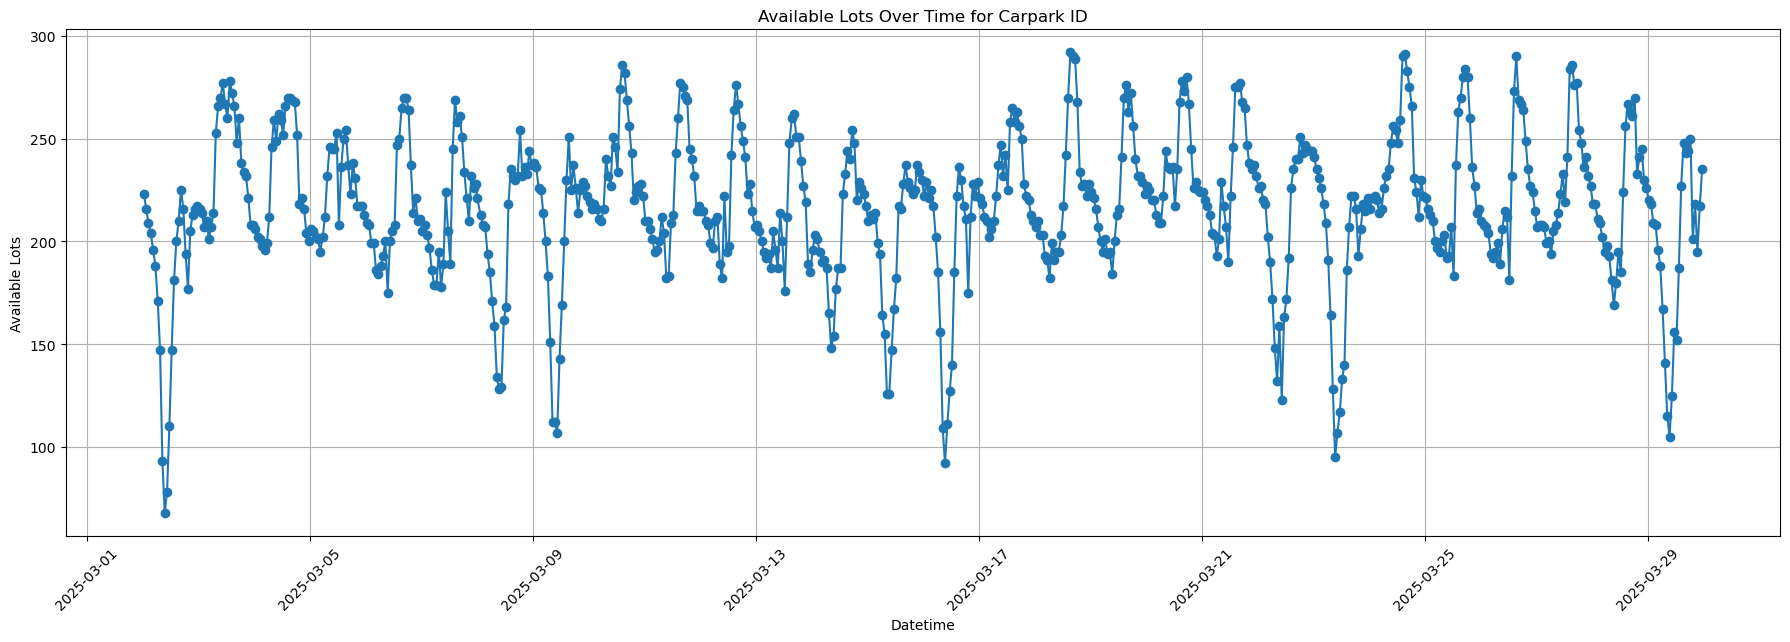

In [51]:
plt.figure(figsize=(18, 6))
plt.plot(df_cp1['timestamp'], df_cp1['available_lots'], marker='o', linestyle='-')
plt.title('Available Lots Over Time for Carpark ID')
plt.xlabel('Datetime')
plt.ylabel('Available Lots')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [4]:
# filter 'C' lot_type
carpark_avail = carpark_avail[(carpark_avail['lot_type']=='C')]

# drop total_lots and area
carpark_avail = carpark_avail.drop(columns=['total_lots'])
carpark_avail = carpark_avail.drop(columns=['area'])

# drop duplicates
carpark_avail = carpark_avail[~((carpark_avail['agency'] == 'HDB') & (carpark_avail['source'] == 'lta'))]
carpark_avail = carpark_avail.drop(columns=['source'])
carpark_avail = carpark_avail.drop(columns=['agency'])

carpark_avail['hour'] = carpark_avail['timestamp'].dt.hour
carpark_avail['minute'] = carpark_avail['timestamp'].dt.minute
carpark_avail['day_of_week'] = carpark_avail['timestamp'].dt.dayofweek
carpark_avail['is_weekend'] = carpark_avail['day_of_week'].isin([5, 6]).astype(int)

# Drop rows with missing target
carpark_avail = carpark_avail.dropna(subset=['available_lots'])

# Drop records with invalid available_lots values (<0 or >5000)
carpark_avail = carpark_avail[(carpark_avail['available_lots'] >= 0) & (carpark_avail['available_lots'] <= 5000)]


In [ ]:
# load carparkinfo data
carpark_info = pd.read_csv("carpark_information.csv")
carpark_info['carpark_id'] = carpark_info['carpark_id'].astype(str)
carpark_info = carpark_info.dropna(subset=['area'])

df = pd.merge(carpark_avail, carpark_info[['carpark_id', 'area', 'agency', 'total_lots']],
              on='carpark_id', how='inner')

In [6]:
print(df.head())

  carpark_id  development           location  available_lots lot_type  \
0          1  Suntec City  1.29375 103.85718            2700        C   
1          1  Suntec City  1.29375 103.85718            2405        C   
2          1  Suntec City  1.29375 103.85718            2855        C   
3          1  Suntec City  1.29375 103.85718            2512        C   
4          1  Suntec City  1.29375 103.85718             675        C   

            timestamp update_datetime  hour  minute  day_of_week  is_weekend  \
0 2025-03-15 00:08:50            <NA>     0       8            5           1   
1 2025-03-08 23:08:50            <NA>    23       8            5           1   
2 2025-03-15 03:08:50            <NA>     3       8            5           1   
3 2025-03-04 22:08:50            <NA>    22       8            1           0   
4 2025-03-04 16:08:50            <NA>    16       8            1           0   

            area agency  total_lots  
0  DOWNTOWN CORE    LTA      2870.0  
1  D

In [7]:
# check time range
start_time = df['timestamp'].min()
end_time = df['timestamp'].max()
print(f"Time range in dataset: {start_time} → {end_time}")

Time range in dataset: 2025-03-02 00:29:27 → 2025-03-30 07:08:50


In [8]:
def add_lag_features_per_carpark(df, target_col='available_lots', lags=[24]):
    """
    Sort by carpark_id & timestamp, then create lag features.
    Removes rows where lag_24 is NaN.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing 'carpark_id', 'timestamp', and the target_col.
    target_col : str, default='available_lots'
        The column we want to lag.
    lags : list, default=[24]
        A list of lag offsets in 'rows'. Typically, 24 means 24 rows prior
        for hourly data.

    Returns
    -------
    pd.DataFrame
        DataFrame with a new lag_{lag} column for each lag in `lags`.
        Rows with NaN lag values are dropped.
    """
    df = df.sort_values(['carpark_id', 'timestamp']).copy()

    for lag in lags:
        df[f'lag_{lag}'] = df.groupby('carpark_id')[target_col].shift(lag)

    # Drop rows where lag_24 is NaN
    df = df[df['lag_24'].notna()]
    return df


In [9]:
# Label encode 'area','agency'
le_area = LabelEncoder()
le_agency = LabelEncoder()
df['area_encoded'] = le_area.fit_transform(df['area'])
df['agency_encoded'] = le_agency.fit_transform(df['agency'])

# One-Hot Encode 'carpark_id'
carpark_dummies = pd.get_dummies(df['carpark_id'], prefix='carpark')

In [10]:
print(le_area.classes_)
print(le_agency.classes_)

['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CHANGI' 'CHOA CHU KANG' 'CLEMENTI' 'DOWNTOWN CORE'
 'GEYLANG' 'HOUGANG' 'JURONG EAST' 'JURONG WEST' 'KALLANG' 'MARINE PARADE'
 'MUSEUM' 'NEWTON' 'NOVENA' 'ORCHARD' 'OUTRAM' 'PASIR RIS' 'PUNGGOL'
 'QUEENSTOWN' 'ROCHOR' 'SEMBAWANG' 'SENGKANG' 'SERANGOON'
 'SINGAPORE RIVER' 'SOUTHERN ISLANDS' 'TAMPINES' 'TANGLIN' 'TENGAH'
 'TOA PAYOH' 'WOODLANDS' 'YISHUN']
['HDB' 'LTA' 'URA']


In [12]:
# check no of rows 
print(df.shape[0], carpark_dummies.shape[0])
print(carpark_dummies.head())

1366635 1366635
     carpark_1  carpark_11  carpark_12  carpark_13  carpark_14  carpark_15  \
198       True       False       False       False       False       False   
190       True       False       False       False       False       False   
74        True       False       False       False       False       False   
50        True       False       False       False       False       False   
533       True       False       False       False       False       False   

     carpark_16  carpark_17  carpark_18  carpark_19  ...  carpark_Y79L  \
198       False       False       False       False  ...         False   
190       False       False       False       False  ...         False   
74        False       False       False       False  ...         False   
50        False       False       False       False  ...         False   
533       False       False       False       False  ...         False   

     carpark_Y79M  carpark_Y8  carpark_Y80M  carpark_Y81M  carpark_Y82

In [13]:
# concat df and carpark_dummies
df = pd.concat([df, carpark_dummies], axis=1)

In [14]:
# Sort by Timestamp
df = df.sort_values(by='timestamp').reset_index(drop=True)

In [15]:
print(df.shape)

(1366635, 2127)


In [16]:
print(df.head(30))

   carpark_id                                development  \
0           1                                Suntec City   
1       A0021                     AMOY STREET OFF STREET   
2          50                                VivoCity P2   
3       S0150     SULTAN GATE - ALIWAL STREET OFF STREET   
4       L0064               LORONG 21 GEYLANG OFF STREET   
5          23                                ION Orchard   
6       K0121              KAMPONG KAPOR ROAD OFF STREET   
7           5                         Millenia Singapore   
8       A0024           ADAM ROAD FOOD CENTRE OFF STREET   
9       S0166  SEMBAWANG RD-ADMIRALTY RD EAST OFF STREET   
10      L0078                    LORONG MYDIN OFF STREET   
11      B0031                     BEATTY ROAD OFF STREET   
12         43                                   Westgate   
13      A0035                    ANTHONY ROAD OFF STREET   
14         20                             Far East Plaza   
15      H0057  HINDOO ROAD-KAMPONG KAPOR

In [27]:
feature_columns = [
    'hour', 'day_of_week', 'is_weekend','total_lots',
    'area_encoded', 'agency_encoded', 
    'lag_24'
] + list(carpark_dummies.columns) 

# feature_columns = ['hour', 'day_of_week', 'is_weekend','total_lots','area_encoded', 'agency_encoded', 'lag_24','rolling_mean_3', 'rolling_std_3'
# ] + list(carpark_dummies.columns) 
X = df[feature_columns]
y = df['available_lots']

In [28]:
print(X.shape)
print(y.shape)
print(carpark_dummies.shape)

(1366635, 2115)
(1366635,)
(1366635, 2108)


In [29]:
# Time-based split: train, test
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
y_train = y.iloc[:split_index]
X_test = X.iloc[split_index:]
y_test = y.iloc[split_index:]

In [30]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [31]:
# check feature importance
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# top 20 important feature
print(importance_df.head(20))

             feature  importance
6             lag_24    0.774855
556     carpark_CKM5    0.055391
23        carpark_26    0.025927
4       area_encoded    0.024580
14        carpark_17    0.018248
3         total_lots    0.017830
546     carpark_CK78    0.014427
924     carpark_JS3L    0.009848
0               hour    0.003366
592      carpark_DRS    0.002907
1        day_of_week    0.002481
46         carpark_9    0.002421
28         carpark_5    0.002354
5     agency_encoded    0.002295
520     carpark_CK52    0.002248
13        carpark_16    0.002067
17         carpark_2    0.001828
1118    carpark_PDJ7    0.001613
972      carpark_KM3    0.001548
1399    carpark_SE17    0.001544


In [32]:
# Evaluate performance
y_pred =model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Model RMSE: {rmse:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Model R²:", r2)

Model RMSE: 24.36
Model R²: 0.9880286741455917


In [23]:
df_test = df.iloc[split_index:].copy()
df_test['y_pred'] = y_pred

rmse_per_carpark = df_test.groupby('carpark_id').apply(
    lambda g: np.sqrt(mean_squared_error(g['available_lots'], g['y_pred']))
).sort_values(ascending=False)

print(rmse_per_carpark.head(10))

carpark_id
26      468.971304
1       405.106168
16      164.544682
2       155.483393
SK24    123.144847
PDJ7    115.232851
53      112.340017
9       109.629320
61      109.522331
5       109.134346
dtype: float64


C:\Users\user\AppData\Local\Temp\ipykernel_2912\3640896370.py:9: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\user\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


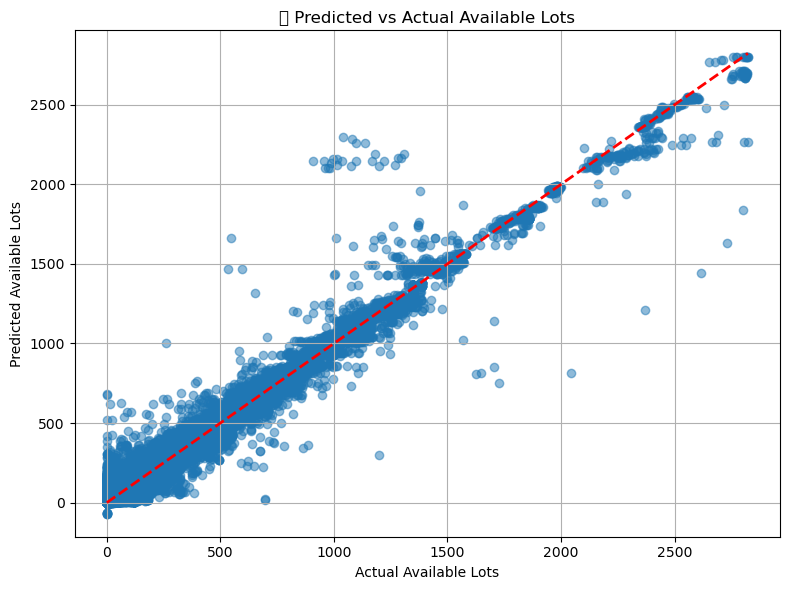

In [42]:
# === Plot predicted vs actual values ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Available Lots")
plt.ylabel("Predicted Available Lots")
plt.title("🔍 Predicted vs Actual Available Lots")
plt.grid(True)
plt.tight_layout()
plt.show()

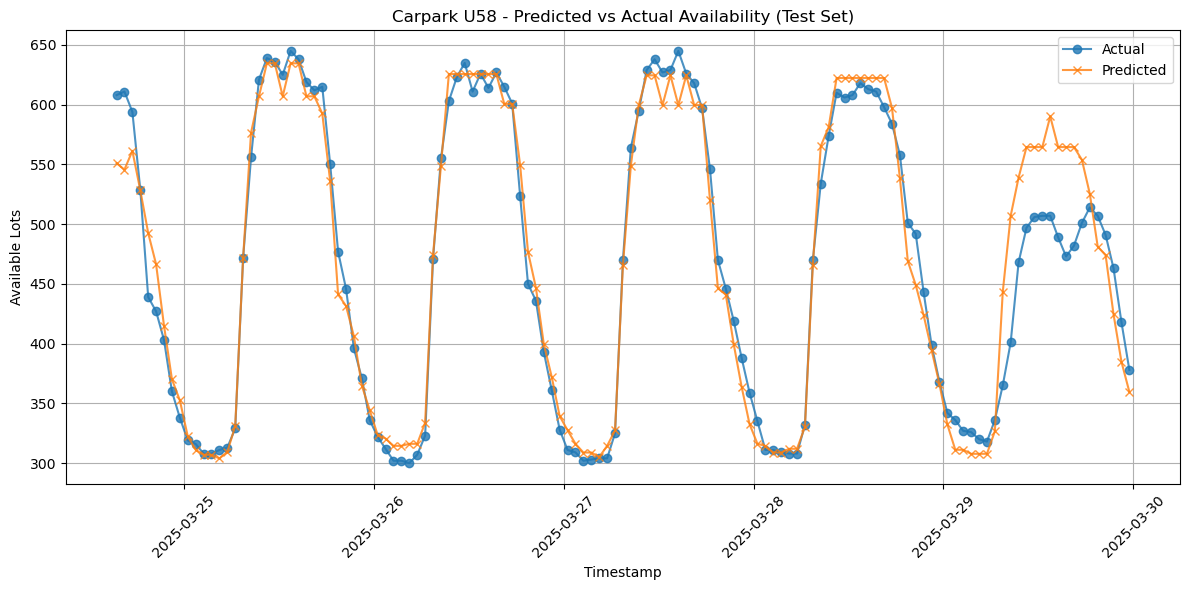

In [41]:
# Step 1: Reconstruct prediction DataFrame
# Add timestamp + carpark_id back to y_test
test_meta = df.iloc[split_index:][['timestamp', 'carpark_id']].reset_index(drop=True)

# Combine into result DataFrame
pred_df = pd.DataFrame({
    'timestamp': test_meta['timestamp'],
    'carpark_id': test_meta['carpark_id'],
    'actual': y_test.reset_index(drop=True),
    'predicted': y_pred
})

# Step 2: Filter by carpark_id (e.g. 'U58')
carpark_id = 'U58'
filtered = pred_df[pred_df['carpark_id'] == carpark_id].copy()

# Step 3: Sort by time
filtered = filtered.sort_values('timestamp')

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.plot(filtered['timestamp'], filtered['actual'], label='Actual', marker='o', alpha=0.8)
plt.plot(filtered['timestamp'], filtered['predicted'], label='Predicted', marker='x', alpha=0.8)
plt.title(f'Carpark {carpark_id} - Predicted vs Actual Availability (Test Set)')
plt.xlabel('Timestamp')
plt.ylabel('Available Lots')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [43]:
## best model -- get the hyperparameter using optuna
best_model =  xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=163,
    max_depth=10,
    learning_rate=0.1030,
    subsample=0.9682,
    colsample_bytree=0.9914,
    random_state=42
)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9914, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.103, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=163, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [47]:
# Evaluate performance
y_pred_best =best_model.predict(X_test)

best_mse = mean_squared_error(y_test, y_pred_best)
best_rmse = np.sqrt(best_mse)
print(f"Best Model RMSE: {best_rmse:.2f}")

best_r2 = r2_score(y_test, y_pred_best)
print(f"Best Model R²:", best_r2)

Best Model RMSE: 21.44
Best Model R²: 0.9907254241173172


In [45]:
# check feature importance
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# top 20 important feature
print(importance_df.head(20))

           feature  importance
556   carpark_CKM5    0.240838
6           lag_24    0.165460
924   carpark_JS3L    0.104604
23      carpark_26    0.073380
520   carpark_CK52    0.051677
14      carpark_17    0.012541
1546  carpark_SK94    0.006280
17       carpark_2    0.005776
3       total_lots    0.005321
1556   carpark_SMM    0.004815
1474  carpark_SK27    0.004466
212    carpark_B79    0.004401
1547  carpark_SK95    0.004332
7        carpark_1    0.004075
596   carpark_DUXM    0.003967
598   carpark_DWSP    0.003282
1399  carpark_SE17    0.003251
1515  carpark_SK66    0.003180
422    carpark_C10    0.002876
454    carpark_C3M    0.002772


In [49]:
# Save the XGB best model
with open("xgb_carpark_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Save the XGB model
with open("xgb_carpark_model.pkl", "wb") as f:
    pickle.dump(model, f)

# Save the fitted LabelEncoders
with open("le_area.pkl", "wb") as f:
    pickle.dump(le_area, f)
    
with open("le_agency.pkl", "wb") as f:
    pickle.dump(le_agency, f)

# 1) Create a list of distinct carpark IDs used in training
carpark_ids_list = df['carpark_id'].unique().tolist()

# 2) Save (pickle) this list
with open("carpark_id_list.pkl", "wb") as f:
    pickle.dump(carpark_ids_list, f)

print("Distinct carpark IDs saved:", len(carpark_ids_list))

with open("training_feature_columns.pkl", "wb") as f:
    pickle.dump(feature_columns, f)



Distinct carpark IDs saved: 2108
